In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

/share/python-virtual-environments/ciona_behaviour-v2/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import os
import sys

In [3]:
from openTSNE import TSNE

In [4]:
import tqdm
import time
import json
from joblib import Parallel, delayed
from itertools import islice

import pickle
import h5py 
import random
from scipy import signal
from numpyencoder import NumpyEncoder

In [ ]:
skel_feats_path = "../../data/dlc_results/feats_combined_glutgaba_drugs_Jan31.pickle"

In [ ]:
skel_meta_path = '../../data/dlc_results/ref_metadataframe_drugs_Jan26.pickle'

In [ ]:
df_features = pd.read_pickle(skel_feats_path)

In [ ]:
df_features.columns

In [ ]:
df_meta = pd.read_pickle(skel_meta_path)
df_meta.head()

# Remove outliers

In [ ]:
def remove_outliers(df, col, thresh=[0,60]):
    # global outlier_free_list 
    global df_wo_outliers

    if col.startswith('curv'):
        Q1, Q3 = df[col].quantile([.25, .75])
        IQR = Q3 - Q1
        
        thresh[0] = Q1 - 7 * IQR
        thresh[1] = Q3 + 7 * IQR
        df_wo_outliers = df[(df[col] > thresh[0]) & (df[col] < thresh[1])]

        
    elif col.startswith('speed'):
        df_wo_outliers = df[((df[col] > 0) & (df[col] < thresh[1]))]

In [ ]:
cols_curv = list(df_features.filter(like='curv').columns)

In [ ]:
cols_speed = list(df_features.filter(like='speed').columns)

In [ ]:
fig, axes = plt.subplots(2,7,figsize=(35,5))

for i, col in enumerate(cols_curv):
    hist = df_features[col].hist(bins=60, ax=axes[0][i])
    hist1 = df_features.loc[((df_features[col]>-1) & (df_features[col]<1)),col].hist(bins=60, ax=axes[1][i])
    
    Q1, Q3 = df_features[col].quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 7*IQR
    high_thresh = Q3 + 7*IQR
    ymin, ymax = hist.get_ylim()
    axes[0][i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='k', linestyles='dotted')
    ymin1, ymax1 = hist1.get_ylim()
    axes[1][i].vlines(x=[low_thresh, high_thresh], ymax= ymax1, ymin=ymin1, colors='k', linestyles='dotted')

In [ ]:
remove_outliers(df_features, cols_curv[0])

In [ ]:
for i, col in enumerate(cols_curv[1:]):
    remove_outliers(df_wo_outliers, col)

In [ ]:
len(df_wo_outliers.index) / len(df_features.index)

In [ ]:
len(df_features.index)

In [ ]:
fig, axes = plt.subplots(1,7,figsize=(20, 4))
dict_thresh_speeds = {}
axes = axes.ravel()
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)

for i, col in enumerate(cols_speed):
    sel_data = df_wo_outliers[col]
    print(col, sel_data.shape)
    sel_data = sel_data[(sel_data.notna())]
    log_vals = np.log(sel_data)
    hist = log_vals[(log_vals!=np.inf)&(log_vals!=-1*np.inf)&(log_vals!=np.nan)].hist(ax =axes[i], bins=60)
    
    Q1, Q3 = log_vals.quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 1.5*IQR
    high_thresh = Q3 + 1.5*IQR

    dict_thresh_speeds[col] = [np.exp(low_thresh), np.exp(high_thresh)]

    print(np.exp(low_thresh), np.exp(high_thresh))
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

In [ ]:
fig, axes = plt.subplots(1,7,figsize=(20, 4))
axes = axes.ravel()
for i, col in enumerate(cols_speed):
    hist = df_wo_outliers.loc[(df_wo_outliers[col] >= 0) & (df_wo_outliers[col] < 60), col].hist(ax=axes[i], bins=60)
    
    low_thresh, high_thresh = dict_thresh_speeds[col]
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

In [ ]:
for i, col in enumerate(cols_speed):
    remove_outliers(df_wo_outliers, col, dict_thresh_speeds[col])

In [ ]:
len(df_wo_outliers.index) / len(df_features.index)

# Features for further analysis

In [ ]:
df_all = df_wo_outliers.filter(items = ['ects_1', 'ects_2', 'ects_3', 'ects_4', 'ects_5',
       'ects_6', 'quirkness', 'speed_neck', 'speed_tail_base', 'speed_tail_pre_mid', 'speed_tail_mid',
       'speed_tail_post_mid', 'speed_tail_tip', 'frames', 'filename', 'filedir', 'drug'])

In [ ]:
meta_df = pd.read_pickle(skel_meta_path)

In [ ]:
df_files = df_all.groupby(by = 'filename')

In [ ]:
fnames = list(df_all.filename.unique())

In [ ]:
len(fnames)

In [ ]:
df_tsne_exps = []
for fname in fnames:
    df_tsne_exps.append(df_files.get_group(fname))

In [ ]:
df_all_2874 = pd.concat(df_tsne_exps)

# Sampling using Speed

In [ ]:
n_samples = 200000
n_samplesk = n_samples// 1000

In [ ]:
feat_coeff_dict = {'speed_neck': 0.3, 'speed_tail_base': 0.1, 'speed_tail_pre_mid': 0.1,
                    'speed_tail_mid': 0.3, 'speed_tail_post_mid': 0.1, 'speed_tail_tip': 0.1}

In [ ]:
def nearest_neighbours(test_val, lst):
    for i, l in enumerate(zip(lst, islice(lst, 1, None))):
        l1 = l[0]
        l2 = l[1]
        if l1 <= test_val <= l2:
#             return l1, l2, i, 1 / x_hist[i]
            return (1/x_hist[i])
#         else :
#             return 1/x_hist[-1]

In [ ]:
feat_weights_df = pd.DataFrame()

In [ ]:
for key, coeff in tqdm.tqdm(feat_coeff_dict.items()):
    
    x_hist, x_ed = np.histogram(df_features[key], bins =100, density=1)
    
    weights = df_all[key].apply(lambda y: nearest_neighbours(y, x_ed))
    
    feat_weights_df[key] = weights * coeff

In [ ]:
feat_weights_df['final_weights'] = feat_weights_df.sum(axis=1) 

In [ ]:
df_samples = df_all.sample(n = n_samples, weights = feat_weights_df['final_weights'])

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,5))
axes = axes.ravel()
df_all['speed_neck'].hist(bins=100, ax= axes[0])
df_all['speed_tail_mid'].hist(bins=100, ax= axes[1])
df_all['speed_tail_tip'].hist(bins=100, ax= axes[2])

df_samples['speed_neck'].hist(bins=100, ax= axes[3])
df_samples['speed_tail_mid'].hist(bins=100, ax= axes[4])
df_samples['speed_tail_tip'].hist(bins=100, ax= axes[5])

axes[0].set_title('speed neck orig')
axes[1].set_title('speed tail_mid orig')
axes[2].set_title('speed tail_tip orig')
axes[3].set_title('speed neck sampled')
axes[4].set_title('speed tail_mid sampled')
axes[5].set_title('speed tail_tip sampled')

plt.tight_layout()

In [ ]:
df_samples.to_pickle('/data/longterm/10/athira/Aug28_glutgaba_WTdrugs_sampled_2874.pickle')

# Wavelet calculations

In [ ]:
feats_list = ['ects_1', 'ects_2', 'ects_3', 'ects_4', 'ects_5', 'ects_6']

In [ ]:
df_feats_selected = []
for df in df_tsne_exps:
    df_feats_selected.append(df.filter(items = feats_list + ['filename', 'frames']))

In [ ]:
df_feats_selected[0]

## Wavelets

In [ ]:
# Parameters

fs = 30 # Sampling frequency
omg0 = 6 # omega0 for the wavelet
fs_ny = fs/2 # Nyquist frequency of the system

In [ ]:
# 30 scales linearly spaced, max being sampling frequency  + 1

f_channels = np.arange(1, fs +1, 1)
# f_channels = np.arange(1, fs +1, 1)
widths = omg0*fs / (2*f_channels*np.pi) 

print(f_channels, len(widths))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def wv_transform(df, widths, omg0):
    
    df_wv = pd.DataFrame()
    df_wv['filename'] = df['filename']
    df_wv['frames'] = df['frames']
    
    df.drop(['filename', 'frames'], axis=1, inplace = True)


    for feat in list(df.columns):
#         scaler = MinMaxScaler()

        ts = df[feat].values
        cwtm = signal.cwt(ts, signal.morlet2, widths, w = omg0)

        wv_feat = np.abs(cwtm)
#         if feat == 'curv_neck':
#         wv_feat = scaler.fit_transform(wv_feat)
        
        for f in range(len(widths)):
            df_wv[f'{feat}_wv{f}'] = wv_feat[f-1,:]
    
    return df_wv

In [ ]:
fnames_sampled = list(df_samples.filename.unique())

In [ ]:
print(len(fnames_sampled))

In [ ]:
df_wv_transforms = Parallel(n_jobs=30, verbose = 5)(delayed(wv_transform)(df_files.get_group(fname).filter(items = feats_list + ['filename', 'frames']), widths, omg0) 
                                                for fname in fnames_sampled)
df_wv_combined = pd.concat(df_wv_transforms)

In [ ]:
df_wv_combined.columns

In [ ]:
df_wv_combined.to_pickle(f'/data/longterm/10/athira/Aug28_glutgaba_WTdrugs_wv_combined_{len(fnames_sampled)}.pickle')

## Load precomputed data

In [ ]:
df_samples = pd.read_pickle('/data/longterm/10/athira/Aug28_glutgaba_WTdrugs_sampled_2874.pickle')

In [ ]:
df_wv_combined = pd.read_pickle('/data/longterm/10/athira/Aug28_glutgaba_WTdrugs_wv_combined_2842.pickle')

In [ ]:
df_wv_combined

In [ ]:
df_wv_combined.reset_index(drop = True, inplace = True)

## As input for TSNE

In [ ]:
df_samples.head()

In [ ]:
df_wv_combined.head()

In [ ]:
df_feat_wv_samples = pd.merge(df_samples, df_wv_combined , left_on=['filename','frames'], right_on=['filename','frames'],
        how='left' )

In [ ]:
df_feat_wv_samples.head()

In [ ]:
df_wv_for_tsne = df_feat_wv_samples.filter(like = '_wv')

In [ ]:
df_wv_for_tsne

In [ ]:
df_wv_for_tsne.columns

In [ ]:
df_wv_for_tsne.to_pickle(f'/data/longterm/10/athira/Aug28_glutgaba_WTdrugs_wv_combined_2842_sampled.pickle')

# TSNE

In [5]:
df_wv_for_tsne = pd.read_pickle(f'/data/longterm/10/athira/Aug28_glutgaba_WTdrugs_wv_combined_2842_sampled.pickle')

In [6]:
pd.options.mode.use_inf_as_na = True

In [7]:
df_wv_for_tsne_filt = df_wv_for_tsne.dropna()

In [ ]:
df_wv_for_tsne.shape

In [ ]:
df_wv_for_tsne_filt.shape

In [ ]:
test_tsne = TSNE(n_jobs=50, perplexity = 1000, exaggeration = 2)
test_tsne = test_tsne.fit(df_wv_for_tsne_filt.values)

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (10,10))
axes.scatter(test_tsne[:,0], test_tsne[:,1], s=0.5)

# Optimizing the tsne results

In [8]:
from openTSNE import TSNEEmbedding, affinity, initialization
from openTSNE import initialization

In [9]:
%%time
affinities_annealing = affinity.PerplexityBasedNN(
    df_wv_for_tsne_filt.values,
    perplexity= 500,
    metric="euclidean",
    n_jobs= 46,
    random_state=3,
    method = 'exact'
)

CPU times: user 1d 1h 40s, sys: 2min 24s, total: 1d 1h 3min 5s
Wall time: 38min 54s


In [10]:
%time init = initialization.pca(df_wv_for_tsne_filt.values, random_state=42)

CPU times: user 1.28 s, sys: 91.7 ms, total: 1.37 s
Wall time: 1.37 s


In [11]:
embedding = TSNEEmbedding(
    init,
    affinities_annealing,
    negative_gradient_method="fft",
    n_jobs= 46,
    
)

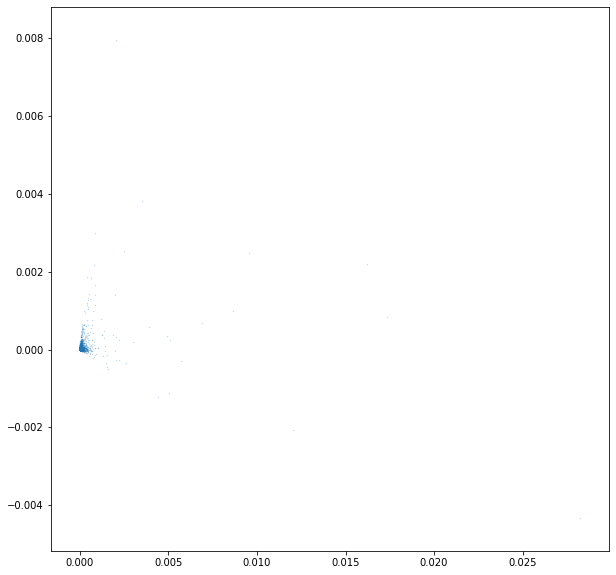

In [12]:
fig, axes = plt.subplots(1,1, figsize = (10,10))

axes.scatter(embedding[:,0], embedding[:,1], s = 0.05, alpha =0.5)

## Perform normal t-SNE optimization with large perplexity


In [13]:
%%time 
embedding1 = embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

CPU times: user 42min 17s, sys: 2.74 s, total: 42min 20s
Wall time: 1min 1s


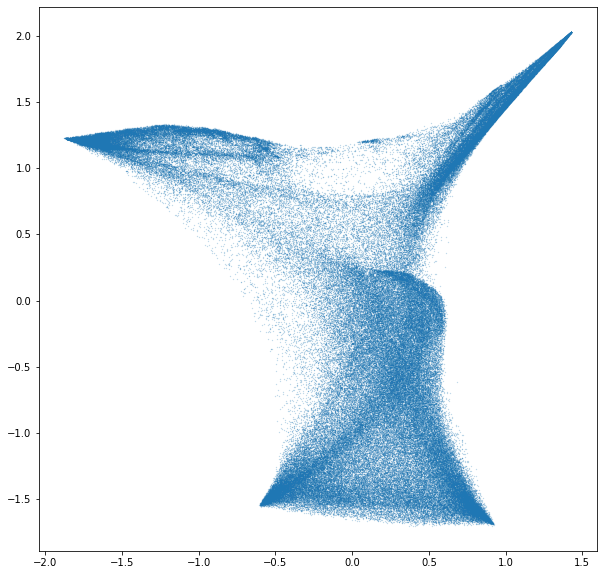

In [14]:
fig, axes = plt.subplots(1,1, figsize = (10,10))

axes.scatter(embedding1[:,0], embedding1[:,1], s = 0.05, alpha =0.5)

In [15]:
%time embedding2 = embedding1.optimize(n_iter=750, exaggeration=1.5, momentum=0.8)

CPU times: user 2h 4min 7s, sys: 4.21 s, total: 2h 4min 11s
Wall time: 2min 58s


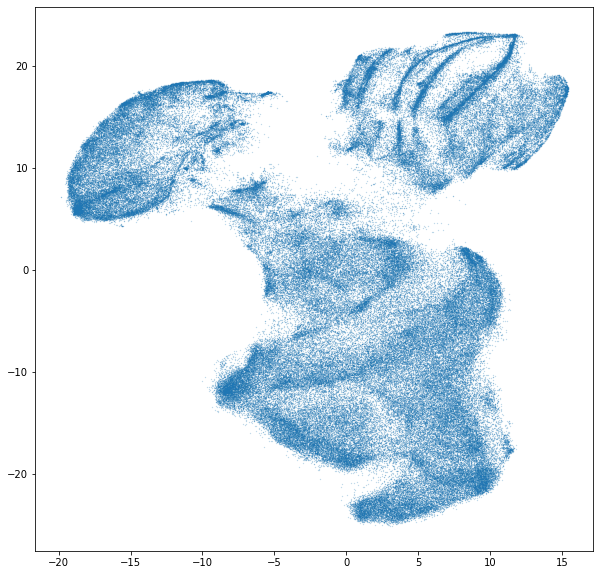

In [16]:
fig, axes = plt.subplots(1,1, figsize = (10,10))
axes.scatter(embedding2[:,0], embedding2[:,1], s = 0.05, alpha =0.5)

## Lower perplexity and optimize

In [60]:
%time affinities_annealing.set_perplexity(50)

CPU times: user 22 s, sys: 507 ms, total: 22.5 s
Wall time: 2.5 s


In [65]:
%time embedding3 = embedding2.optimize(n_iter=500, momentum=0.8, exaggeration=3.5)

CPU times: user 20min 59s, sys: 1.83 s, total: 21min 1s
Wall time: 37.2 s


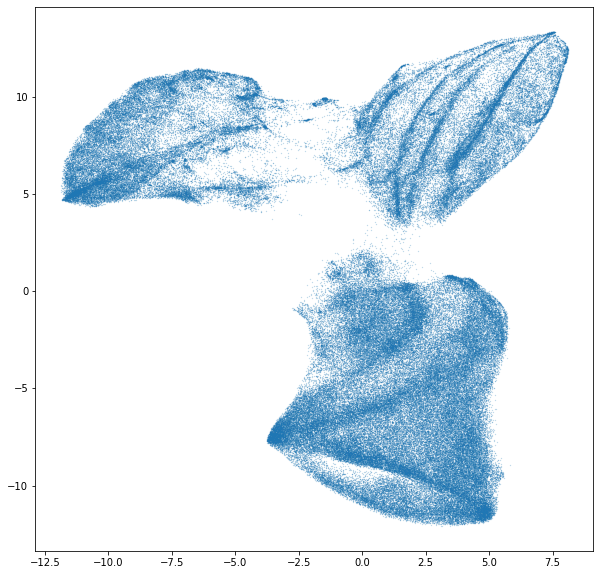

In [66]:
fig, axes = plt.subplots(1,1, figsize = (10,10))
axes.scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5)

In [ ]:
df_feat_wv_samples['quirkness'].hist()

In [ ]:
df_feat_wv_samples.columns

In [47]:
# sum_speed = df_feat_wv_samples.iloc[df_wv_for_tsne_filt.index].filter(like='speed').sum(axis=1)
# sum_to_ann = df_feat_wv_samples.iloc[df_wv_for_tsne_filt.index].filter(like='wv').sum(axis=1)
# quirkiness = df_feat_wv_samples.iloc[df_wv_for_tsne_filt.index]['quirkness'].values

In [48]:
# fig, axes = plt.subplots(2,3, figsize = (15,10))
# axes = axes.ravel()
# axes[0].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = quirkiness, cmap = 'jet')
# axes[1].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = sum_speed, cmap = 'jet')
# axes[2].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = sum_to_ann, cmap = 'jet')

# axes[3].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = df_feat_wv_samples.iloc[df_wv_for_tsne_filt.index]['speed_neck'], cmap = 'jet')
# axes[4].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = df_feat_wv_samples.iloc[df_wv_for_tsne_filt.index]['speed_tail_mid'], cmap = 'jet')
# axes[5].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = df_feat_wv_samples.iloc[df_wv_for_tsne_filt.index]['speed_tail_tip'], cmap = 'jet')
# #
# # axes[0].set_title(f'p={perplexity} {n_samplesk}k samples')
# axes[1].set_title('sum of 3 speeds')
# axes[2].set_title('sum of wavelet feats')
# axes[3].set_title('speed_neck')
# axes[4].set_title('speed_tail_mid')
# axes[5].set_title('speed_tail_tip')

# Clustering the tSNE outputs using DBSCAN 

In [17]:
from sklearn.cluster import DBSCAN

In [31]:
embedding.shape

(200000, 2)

In [37]:
clus_in = embedding3

clustering = DBSCAN(eps = 0.9, min_samples= 500, n_jobs=40).fit(clus_in)
print(clustering.labels_.max())

7


In [38]:
label_map_db = {}
for i, label in enumerate(np.unique(clustering.labels_)):
    label_map_db[label] = i

c_pal_db = sns.color_palette('tab10',len(np.unique(clustering.labels_))+1)

colors_db = [c_pal_db[label_map_db[label]] for label in clustering.labels_]

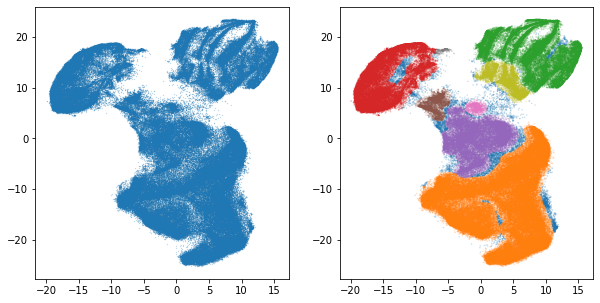

In [39]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))
axes = axes.ravel()
axes[0].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, cmap = 'jet')
axes[1].scatter(embedding3[:,0], embedding3[:,1], s = 0.05, alpha =0.5, c = colors_db)
# fig.savefig('../../results/tsne_dbscan_27082023.png')

# Verifying 

In [ ]:
df_results_samples = df_feat_wv_samples.iloc[df_wv_for_tsne_filt.index]
df_results_samples['clusters'] = clustering.labels_

In [ ]:
df_results_samples.groupby('clusters').mean().filter(like='speed')

## Prediction using kNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors= 2000, n_jobs = 40)

In [ ]:
neigh.fit(embedding3, clustering.labels_)

### Testing on a sample file 

In [ ]:
fn_test = random.sample(fnames, 1)[0]

df_feat_in = df_files.get_group(fn_test)
df_feat_filt_in = df_feat_in.filter(items = feats_list + ['filename', 'frames'])
# get the wavelet features
df_wv_in = wv_transform(df_feat_filt_in, widths, omg0)
df_wv_filt_in = df_wv_in.filter(like = '_wv')


In [ ]:
tsne_in = embedding3.transform(df_wv_filt_in.values)

In [ ]:
test_labels = neigh.predict(tsne_in.data)

In [ ]:
# get the skeleton array
skel_file_root = (meta_df[meta_df['filename']==fn_test])['filepath'].values[0]
print(str(skel_file_root), fn_test)
skel_file = os.path.join(skel_file_root,fn_test)

df_skel = pd.read_hdf(skel_file)
df_skel

In [ ]:
df_skel[df_skel < 0] = np.nan
df_skel = df_skel[(df_skel.iloc[:, df_skel.columns.get_level_values(2) == 'likelihood'] > 0.6).all(axis=1)]
df_skel = df_skel.dropna()

In [ ]:
x = df_skel[('DLC_resnet50_Ciona_trackingMay25shuffle1_500000','p_12','x')]
y = df_skel[('DLC_resnet50_Ciona_trackingMay25shuffle1_500000','p_12','y')]
c_test = [c_pal_db[label_map_db[label]] for label in test_labels]
print(len(x),len(c_test))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20,10))
axes = axes.ravel()
axes[0].scatter(x,y, s = 1, cmap='jet', c = np.arange(len(x))+1)
axes[1].scatter(x,y, s = 1, c = c_test)

In [ ]:
np.unique(test_labels)

In [ ]:
# /data/temp/athira/dlc_analysis/dlc_analysis_lea_WT/results_lea_WT 20190317_174020_1_15m0s_None_None_None_INVERTEDDLC_resnet50_Ciona_trackingMay25shuffle1_500000.h5

### Testing on multiple samples

In [ ]:
sample_fns = random.sample(fnames, 10)

In [ ]:
def get_trace_labeled(fn_test):

    df_feat_in = df_files.get_group(fn_test)
    df_feat_filt_in = df_feat_in.filter(items = feats_list + ['filename', 'frames'])
    # get the wavelet features
    df_wv_in = wv_transform(df_feat_filt_in, widths, omg0)
    df_wv_filt_in = df_wv_in.filter(like = '_wv')
    # find tsne embedding and cluster assignments
    tsne_in = embedding3.transform(df_wv_filt_in.values)

    test_labels = neigh.predict(tsne_in.data)
    # get the skeleton array
    skel_file_root = (meta_df[meta_df['filename']==fn_test])['filepath'].values[0]
    skel_file = os.path.join(skel_file_root,fn_test)

    df_skel = pd.read_hdf(skel_file)
    # remove not-okay frames ! 
    df_skel[df_skel < 0] = np.nan
    df_skel = df_skel[(df_skel.iloc[:, df_skel.columns.get_level_values(2) == 'likelihood'] > 0.6).all(axis=1)]
    df_skel = df_skel.dropna()

    x = df_skel[('DLC_resnet50_Ciona_trackingMay25shuffle1_500000','p_12','x')]
    y = df_skel[('DLC_resnet50_Ciona_trackingMay25shuffle1_500000','p_12','y')]
    c_test = [c_pal_db[label_map_db[label]] for label in test_labels]
    assert(len(x)==len(c_test))
    
    dict_traces = {}
    dict_traces['x'] = x
    dict_traces['y'] = y
    dict_traces['c'] = c_test
    return dict_traces

In [ ]:
sample_fns

In [ ]:
list_traces = Parallel(n_jobs=50, verbose = 5)(delayed(get_trace_labeled)(fn) 
                                                for fn in sample_fns)

In [ ]:
list_traces[0]

In [ ]:
fig, axes = plt.subplots(2, 5, figsize = (25,10))
axes = axes.ravel()
for i in range(10):
    x = list_traces[i]['x']
    y = list_traces[i]['y']
    c = list_traces[i]['c']
    axes[i].scatter(x,y, s = 1, c = c)

### Saving cluster labels 

In [ ]:
def save_cluster_labels(fn_test):

    df_feat_in = df_files.get_group(fn_test)
    df_feat_filt_in = df_feat_in.filter(items = feats_list + ['filename', 'frames'])
    # get the wavelet features
    df_wv_in = wv_transform(df_feat_filt_in, widths, omg0)
    df_wv_filt_in = df_wv_in.filter(like = '_wv')
    # find tsne embedding and cluster assignments
    tsne_in = embedding3.transform(df_wv_filt_in.values)

    test_labels = neigh.predict(tsne_in.data)
    # get the skeleton array
    skel_file_root = (meta_df[meta_df['filename']==fn_test])['filepath'].values[0]
    skel_file = os.path.join(skel_file_root,fn_test)

    df_skel = pd.read_hdf(skel_file)
    # remove not-okay frames ! 
    df_skel[df_skel < 0] = np.nan
    df_skel = df_skel[(df_skel.iloc[:, df_skel.columns.get_level_values(2) == 'likelihood'] > 0.6).all(axis=1)]
    df_skel = df_skel.dropna()

    df_labels = pd.DataFrame()
    df_labels['clus'] = test_labels
    df_labels['filename'] = fn_test
    df_labels['filepath'] = skel_file_root
    df_labels['frames'] = df_skel.index
    
    return df_labels

In [ ]:
df_test = save_cluster_labels(fnames[0])

In [ ]:
df_test.clus.unique()

In [ ]:
def translate(skel_coords, neck_ind):
    
    diff = skel_coords[neck_ind]
    skel_coords_trans = skel_coords - diff
    
    return skel_coords_trans

In [ ]:
def rotate_matrix(skel_array,angle):
    xr = skel_array[:,0]*np.cos(angle) - skel_array[:,1]* np.sin(angle)
    yr = skel_array[:,0]*np.sin(angle) + skel_array[:,1]* np.cos(angle)
    return xr,yr

In [ ]:
def angle(x,y, degrees = False):
    angle = np.arctan2(y,x)
#     if y < 0:
#         angle *=-1
    if not degrees:
        return(angle)
    else:
        return(np.degrees(angle))

In [ ]:
def rotate(x, y, angle):
    xr = x*np.cos(angle) - y* np.sin(angle)
    yr = x*np.sin(angle) + y* np.cos(angle)
    return xr,yr

In [ ]:
clusters = list(df_test.clus.unique())

fig, axes = plt.subplots(1, len(clusters), figsize =(len(clusters) * 4, 4))
skel_path = os.path.join(df_test.filepath[0], df_test.filename[0])
df_skel = pd.read_hdf(skel_path)
df_skel[df_skel < 0] = np.nan
df_skel = df_skel[(df_skel.iloc[:, df_skel.columns.get_level_values(2) == 'likelihood'] > 0.6).all(axis=1)]
df_skel = df_skel.dropna()
df_skel.columns = ['_'.join(col).rstrip('_') for col in df_skel.columns.values]
df_skel['frames'] = df_skel.index
# df_skel_coords = df_skel.iloc[:,df_skel.columns.get_level_values(2)!='likelihood']
for i, clus in enumerate(clusters):
        
    df = df_test[df_test['clus'] == clus]
    
    
    df_clus_samples = pd.merge(df, df_skel , left_on=['frames'], right_on=['frames'],
        left_index=True, how='left' )
    print(len(df.frames), len(df_clus_samples))
    
    df_clus_samples_toplot = df_clus_samples.sample(70)
    
    print(df_clus_samples_toplot.columns)
    x_samples = df_clus_samples_toplot.filter(like='_x')
    y_samples = df_clus_samples_toplot.filter(like='_y')
    
    axes[i].plot(x_samples,y_samples)
    
    